# Python Dependencies

In [707]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import os
from tensorflow.keras import layers
import time
import kaggle
from scipy.fft import fft, fftfreq, ifft

# Defining Constants

In [708]:
# Defining constants
PATH = 'data/'
TRAIN_CSV = PATH + 'train.csv'
TEST_CSV = PATH + 'test.csv'
SUBMISSION_CSV = PATH + 'submission.csv'
TEST_EEGS = PATH + 'test_eegs/'
TRAIN_EEGS = PATH + 'train_eegs/'
TEST_SPECTROGRAMS = PATH + 'test_spectrograms/'
TRAIN_SPECTROGRAMS = PATH + 'train_spectrograms/'

# Defining the duration time for eeg and spectrogram respectively
eeg_duration = 10000
spectrogram_duration = 300


# Fourier General Function

In [709]:
# Assumption:   - The eeg_data is a 1D numpy array
#               - The eeg_data is a time series data
#               - The eeg_data comprises of sums of sine or cosine waves (with a little bit of noise)

# This function takes in an EEG data and plots the original signal, calculates the fourier transform and plots the 
# filtered signal.

# fourier_transform_eeg(eeg_data :: np.array, level_of_detail :: int): 
#                           np.array, int -> np.array(2, level_of_detail)

def fourier_transform_eeg(eeg_data, level_of_detail=10):
    # Creating a list to store the filtered signals
    filtered_signals = [[],[]]

    for i in range(eeg_data.shape[0]):
        # Taking the Fourier transform of the signal
        eeg_data_fft = fft(eeg_data[i])

        amplitude = np.abs(eeg_data_fft)
        frequency = np.angle(eeg_data_fft)

        peak_indicies = np.argsort(amplitude)[::-1][:level_of_detail]
        amplitude = amplitude[peak_indicies]
        frequency = frequency[peak_indicies]

        filtered_signals[0].append(amplitude)
        filtered_signals[1].append(frequency)

    return filtered_signals

In [710]:
def visualize_inverse_fourier(transformed_eeg_data):
    nx = 5
    ny = 4

    figure, axis = plt.subplots(nx, ny, figsize=(20, 20))
    figure.supxlabel("Time(s)")
    figure.supylabel("Voltage (micro volts)")

    for i in range(transformed_eeg_data.shape[1]):
        # Reconstructing the filtered signal using the inverse Fourier transform
        amplitude_and_frequency = transformed_eeg_data[:,i]
        sin_wave_sum_list = np.zeros(eeg_duration)

        for j in range(amplitude_and_frequency.shape[1]):
            amplitude = amplitude_and_frequency[0][j]
            frequency = amplitude_and_frequency[1][j]

            sin_wave = amplitude * np.sin(2 * np.pi / frequency * np.arange(0, eeg_duration))
            sin_wave_sum_list = np.add(sin_wave_sum_list, sin_wave)

        
        axis[i // ny, i % ny].plot(sin_wave_sum_list, 
                                    label="Filtered Signal", 
                                    color="blue")

    plt.show()

In [711]:
def visualize_eeg(eeg_data):
    nx = 5
    ny = 4

    figure, axis = plt.subplots(nx, ny, figsize=(20, 20))
    figure.supxlabel("Time(s)")
    figure.supylabel("Voltage (micro volts)")

    for i in range(eeg_data.shape[0]):
        axis[i // ny, i % ny].plot(eeg_data[i], 
                                    label="Filtered Signal", 
                                    color="red")

    plt.show()

# Loading One Sample Data

In [712]:
train = pd.read_csv(TRAIN_CSV)
test = pd.read_csv(TEST_CSV)

eeg_id = train['eeg_id'][0]
spectrogram_id = train['spectrogram_id'][0]

eeg_offset = train['eeg_label_offset_seconds'][0]
spectrogram_offset = train['spectrogram_label_offset_seconds'][0]

eeg = pd.read_parquet(f'{TRAIN_EEGS}{eeg_id}.parquet').loc[eeg_offset : eeg_offset + eeg_duration - 1,]
eeg = eeg.T.to_numpy()

spectrogram = pd.read_parquet(f'{TRAIN_SPECTROGRAMS}{spectrogram_id}.parquet').loc[spectrogram_offset : spectrogram_offset + spectrogram_duration - 1,]
spectrogram = spectrogram.T.to_numpy()

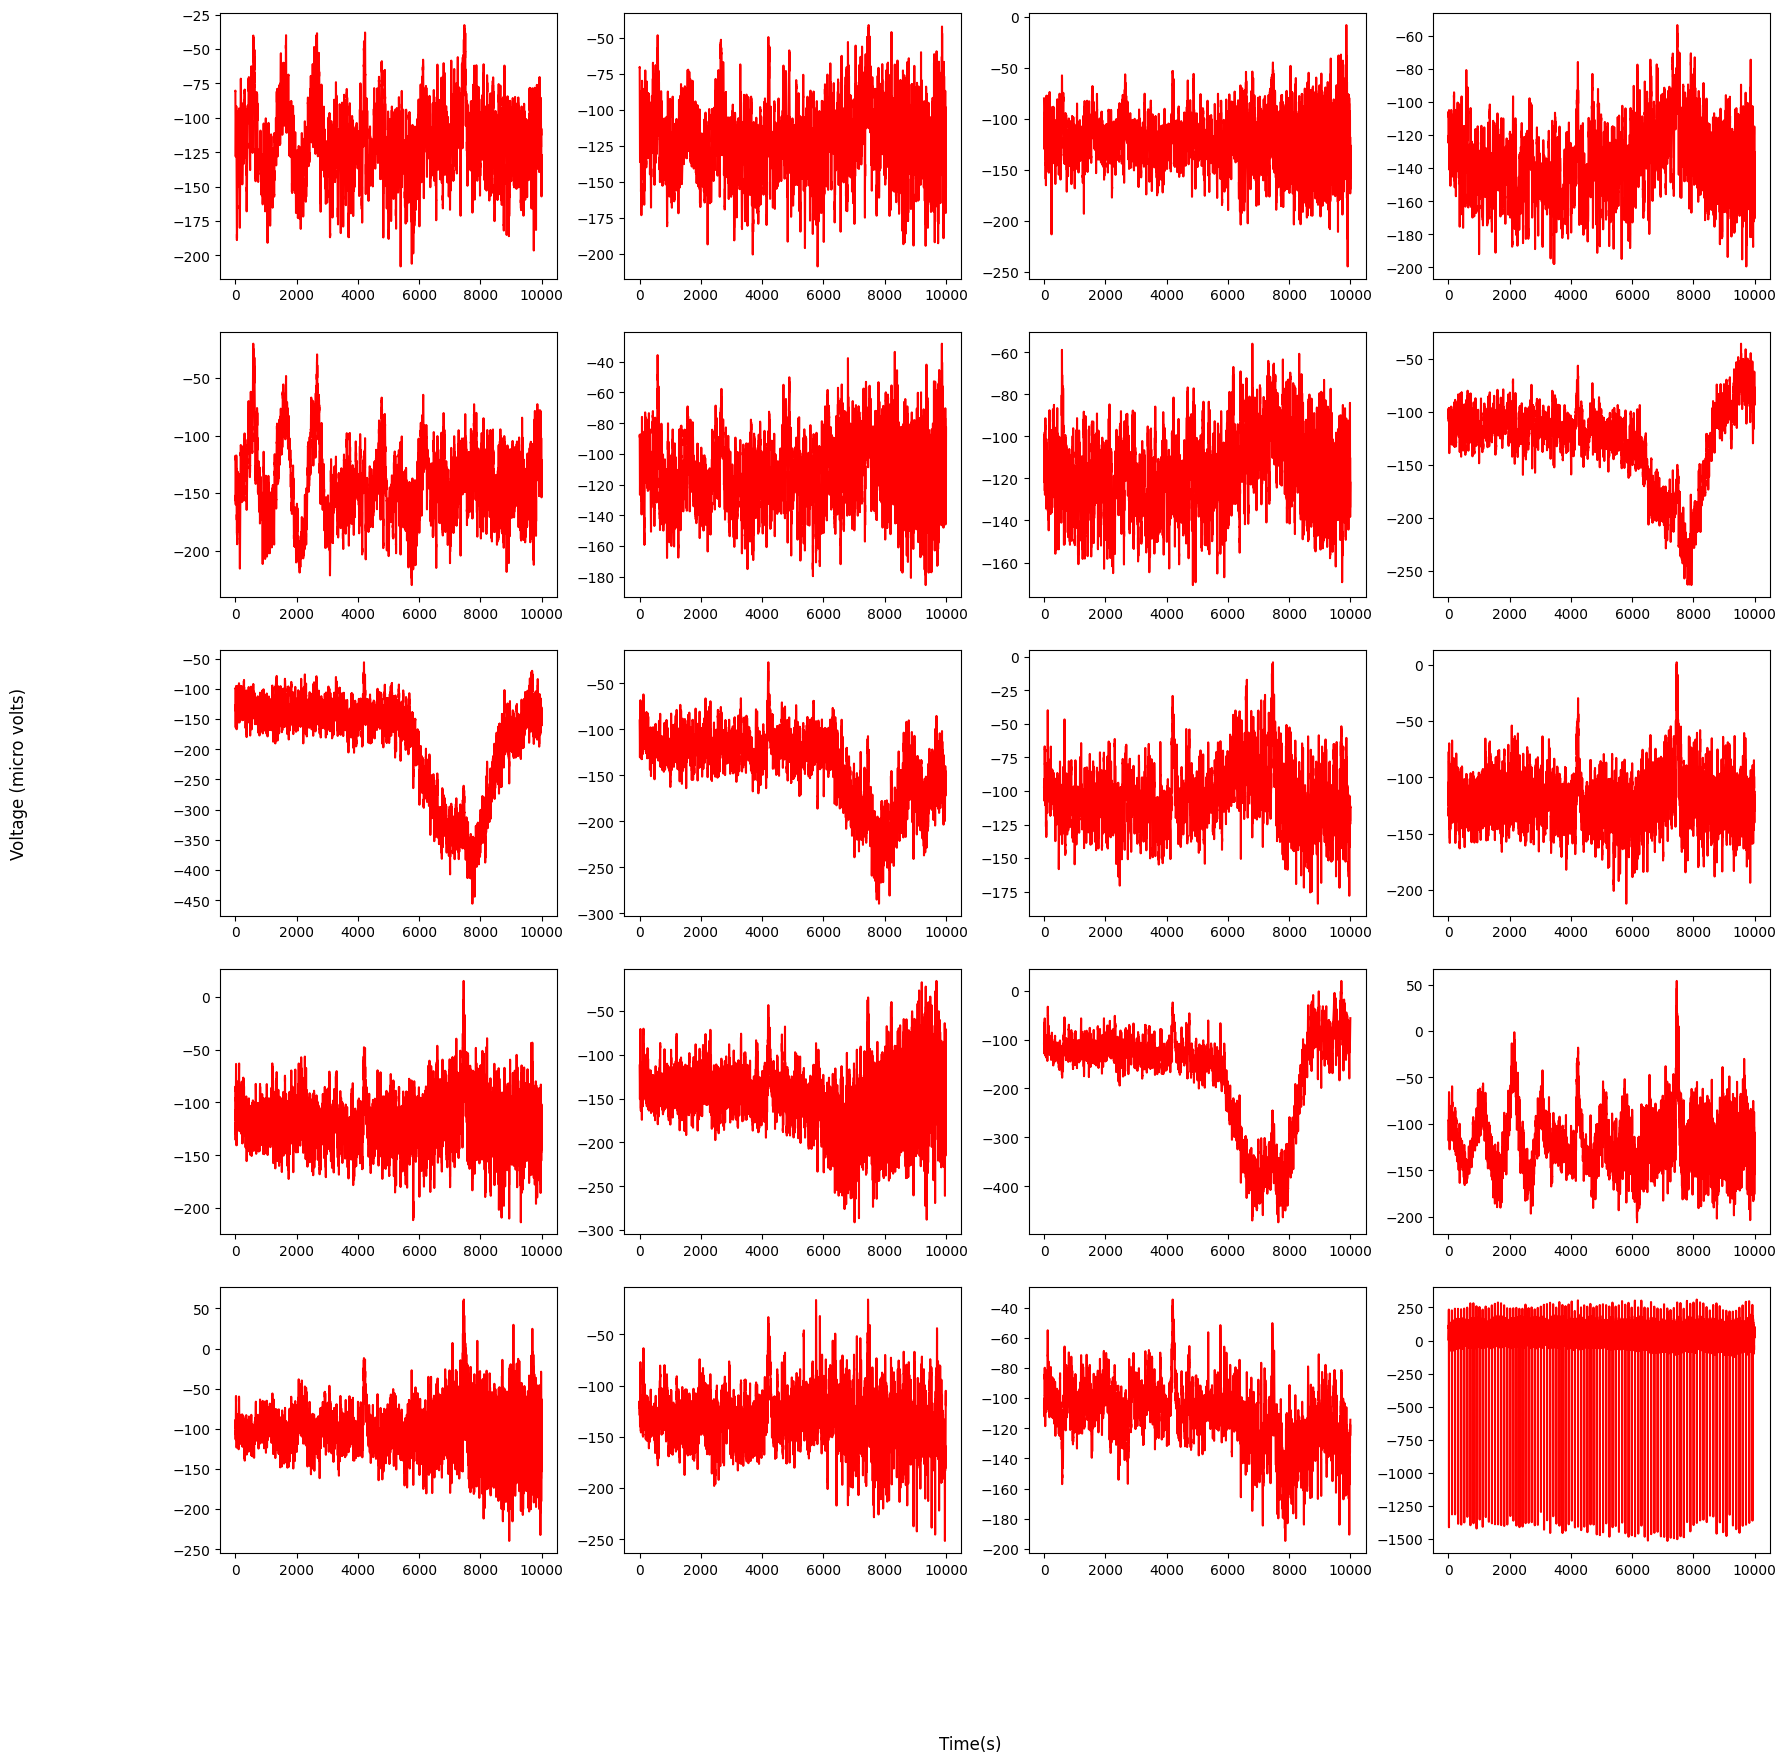

In [713]:
visualize_eeg(eeg)

Size of transformed list:  120000
Shape of transformed list:  (2, 20, 3000)


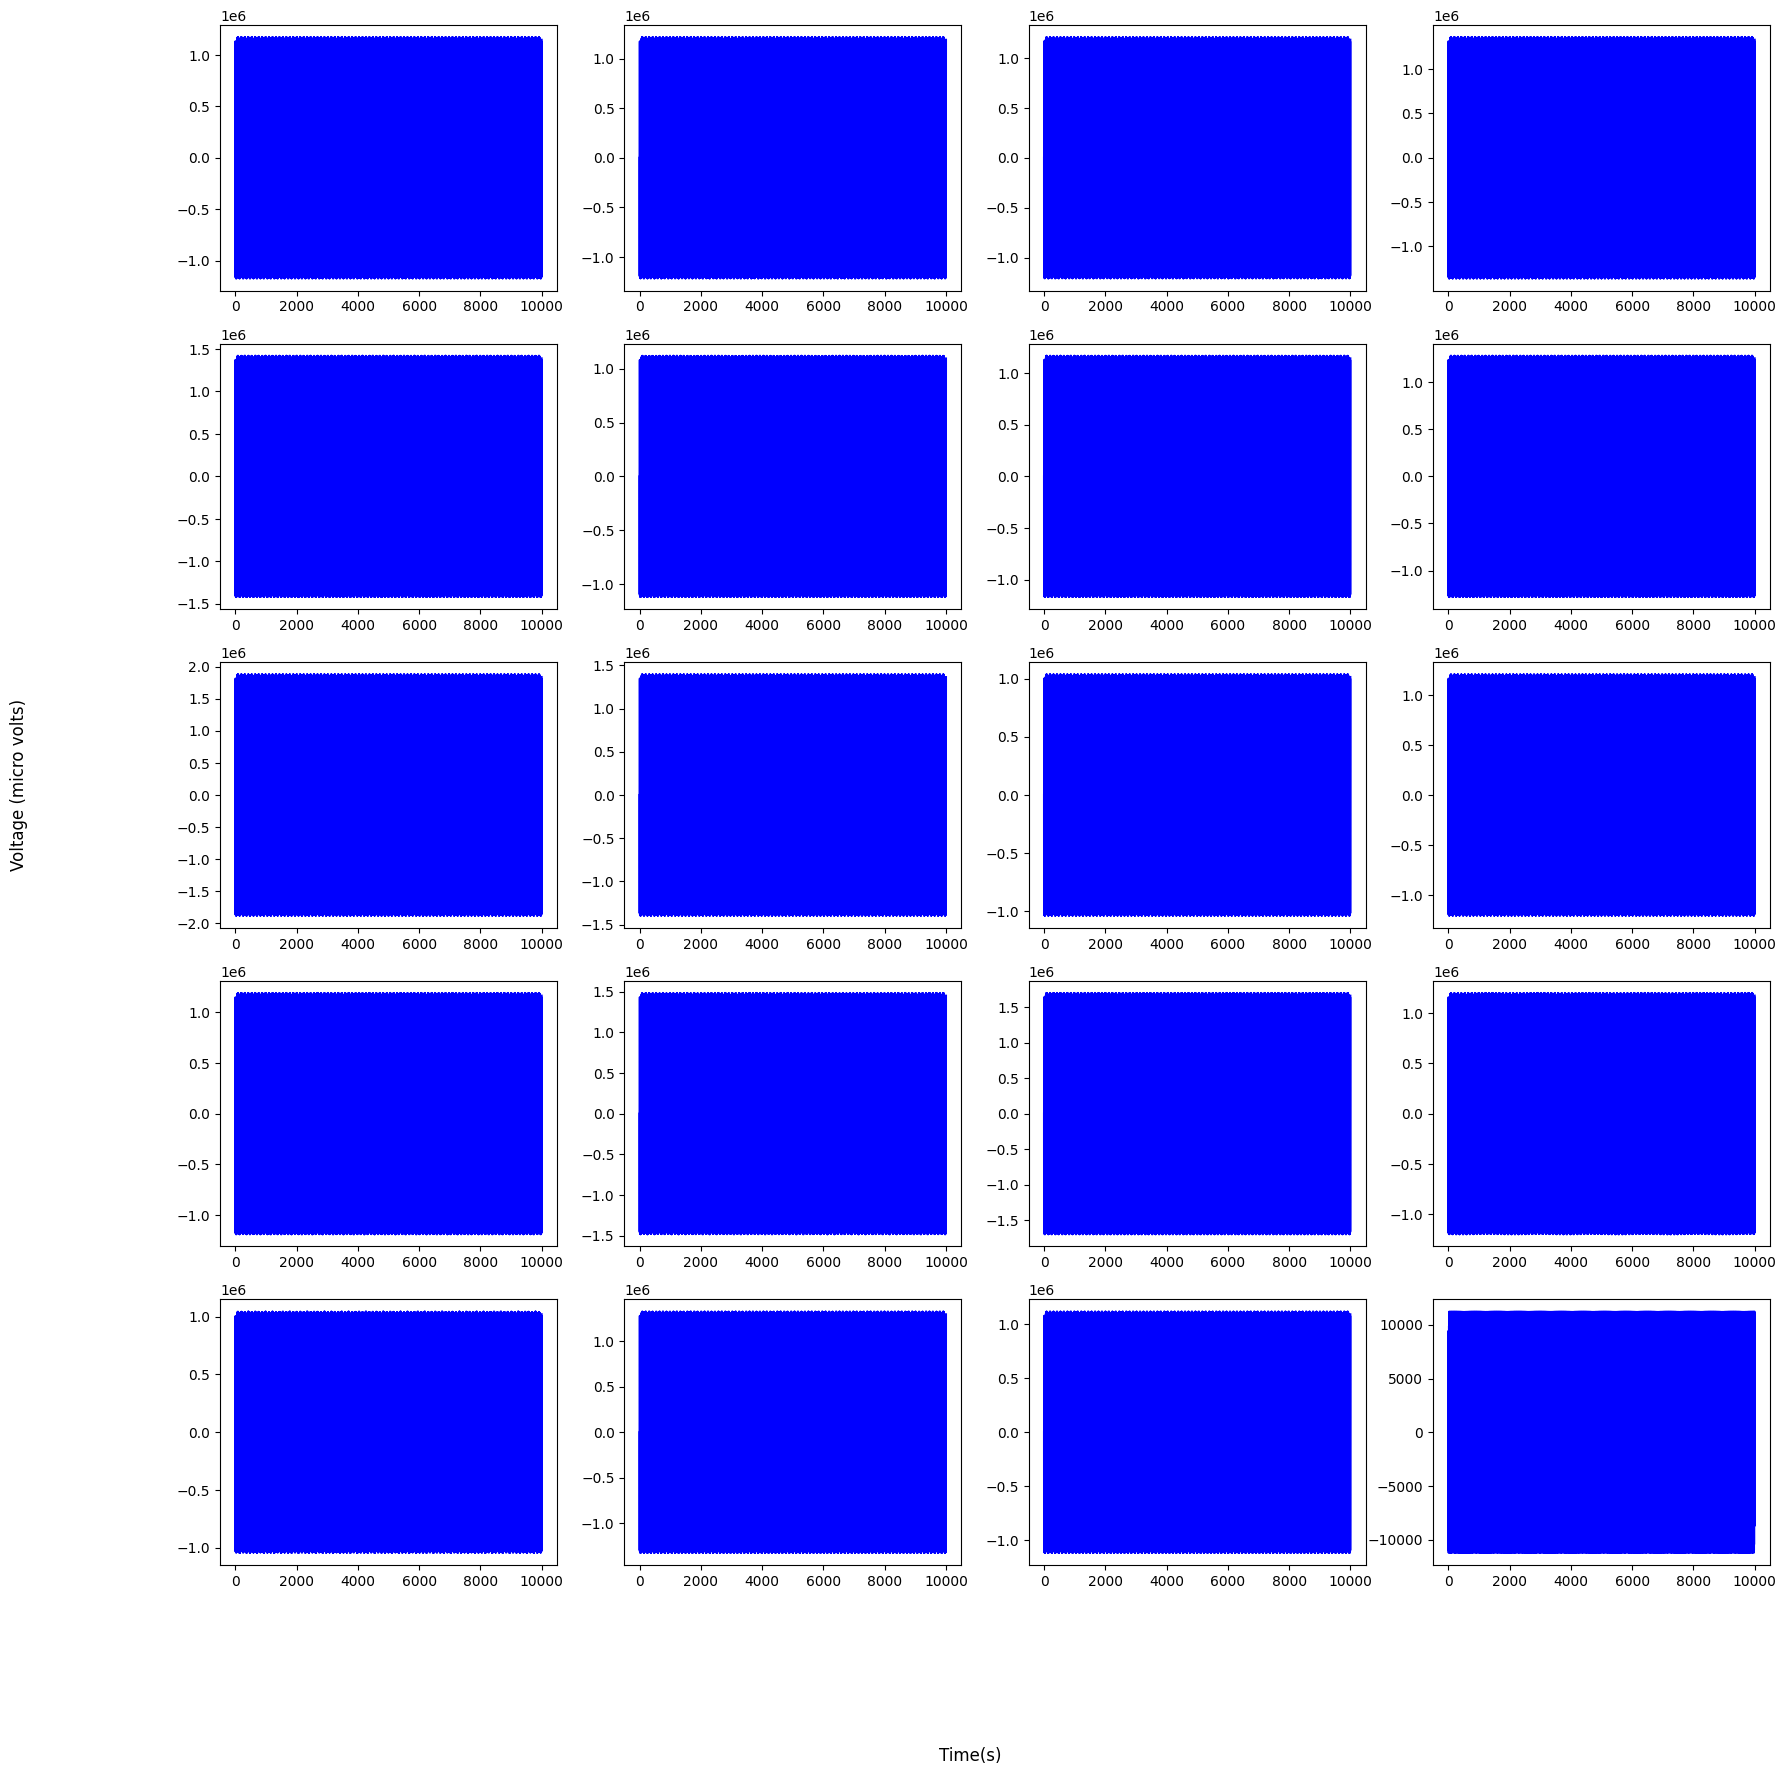

In [714]:
detail = 3000

sample_eeg_fourier_list =  fourier_transform_eeg(eeg, detail)
sample_eeg_fourier_list = np.array(sample_eeg_fourier_list)

print("Size of transformed list: ", sample_eeg_fourier_list.size)
print("Shape of transformed list: ", sample_eeg_fourier_list.shape)

visualize_inverse_fourier(sample_eeg_fourier_list)
